In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import time
import datetime
import gc
import random
import re
import operator

from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split



from keras.layers import *
from keras.models import Model

from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
print(os.listdir("../input/"))

Using TensorFlow backend.


['fakenews-glove', 'ta-rumour-glove']


In [2]:
rumour=np.load('../input/ta-rumour-glove/rumour.npy')
fakenews=np.load('../input/fakenews-glove/fakenews.npy')
# rumour

In [3]:
print(rumour.shape)
print(rumour[4][1])
print(rumour[1][0].shape)

(5331, 2)
non-rumours
(13, 300)


In [4]:
fakenews.shape

(30000, 2)

In [5]:
timesteps=100
embed_dim=300
X_rumour=np.zeros((rumour.shape[0],timesteps,embed_dim))
y_rumour=[]

for i in tqdm(range(0,rumour.shape[0])):
    num_of_sentences=rumour[i][0].shape[0]
    if num_of_sentences>=timesteps:
        X_rumour[i]=rumour[i][0][:timesteps,:]
    else:
        X_rumour[i,-num_of_sentences:]=rumour[i][0]
    y_rumour.append(rumour[i][1])
y_rumour=np.asarray(y_rumour)
print("X shape : ",X_rumour.shape)
print("Y shape : ",y_rumour.shape)

100%|██████████| 5331/5331 [00:00<00:00, 31910.44it/s]

X shape :  (5331, 100, 300)
Y shape :  (5331,)


In [6]:
timesteps=100
embed_dim=300
X_fakenews=np.zeros((fakenews.shape[0],timesteps,embed_dim))
y_fakenews=[]

for i in tqdm(range(0,fakenews.shape[0])):
    num_of_sentences=fakenews[i][0].shape[0]
    if num_of_sentences>=timesteps:
        X_fakenews[i]=fakenews[i][0][:timesteps,:]
    else:
        X_fakenews[i,-num_of_sentences:]=fakenews[i][0]
    y_fakenews.append(fakenews[i][1])
y_fakenews=np.asarray(y_fakenews)
print("X shape : ",X_fakenews.shape)
print("Y shape : ",y_fakenews.shape)   


100%|██████████| 30000/30000 [00:00<00:00, 45686.82it/s]

X shape :  (30000, 100, 300)
Y shape :  (30000,)


In [7]:
y_fakenews

array(['agree', 'agree', 'agree', ..., 'unrelated', 'unrelated',
       'unrelated'], dtype='<U9')

['non-rumours' 'non-rumours' 'non-rumours' ... 'rumours' 'rumours'
 'rumours']


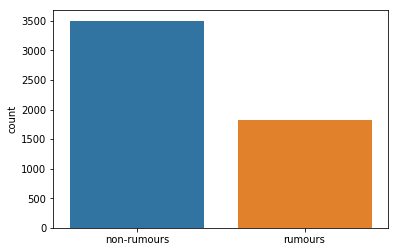

In [8]:
print(y_rumour)
sns.countplot(y_rumour)

In [9]:
rumour_label_dict={"non-rumours":0,"rumours":1}
label_rumour_dict={0:"non-rumours",1:"rumours"}
print(rumour_label_dict["non-rumours"])
print(label_rumour_dict[0])

0
non-rumours


In [10]:
label_rumour=[]
for i in range(0,len(y_rumour)):
    if y_rumour[i]=="non-rumours":
        label_rumour.append(0)
    elif y_rumour[i]=="rumours":
        label_rumour.append(1)

In [11]:
Y_rumour=np.zeros(len(label_rumour))
for i in range(0,len(label_rumour)):
    if label_rumour[i] == 0:
        Y_rumour[i]=0
    elif label_rumour[i] == 1:
        Y_rumour[i]=1
print(Y_rumour.shape)
print(Y_rumour)

(5331,)
[0. 0. 0. ... 1. 1. 1.]


['agree' 'agree' 'agree' ... 'unrelated' 'unrelated' 'unrelated']


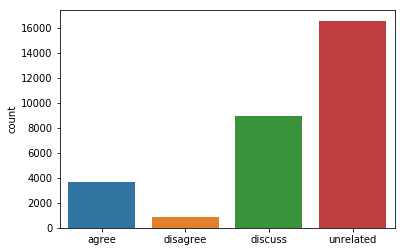

In [12]:
print(y_fakenews)
sns.countplot(y_fakenews)

In [13]:
fakenews_label_dict={"unrelated":0,"agree":1,"disagree":2,"discuss":3}
label_fakenews_dict={0:"unrelated",1:"agree",2:"disagree",3:"discuss"}
print(fakenews_label_dict["unrelated"])
print(label_fakenews_dict[0])

0
unrelated


In [14]:
label_fakenews=[]
for i in range(0,len(y_fakenews)):
    label_fakenews.append(fakenews_label_dict[y_fakenews[i]])
# label_fakenews

In [15]:
Y_fakenews=np.zeros((len(label_fakenews),4))
for i in range(0,len(label_fakenews)):
    if label_fakenews[i] == 0:
        Y_fakenews[i][0]=1
    elif label_fakenews[i] == 1:
        Y_fakenews[i][1]=1
    elif label_fakenews[i] == 2:
        Y_fakenews[i][2]=1
    elif label_fakenews[i] == 3:
        Y_fakenews[i][3]=1
print(Y_fakenews.shape)
print(Y_fakenews)

(30000, 4)
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [16]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [17]:
hidden_units=64
inp=Input(shape=(100,300))
h=GRU(units=64)(inp)

o1=Dense(32,activation='relu')(h)
o1=Dense(8,activation='relu')(o1)
o1=Dense(1,activation='sigmoid')(o1)

o2=Dense(32,activation='relu')(h)
o2=Dense(16,activation='relu')(o2)
o2=Dense(4,activation='softmax')(o2)

rumour_model=Model(inputs=[inp],outputs=[o1])
rumour_model.summary()

fake_model=Model(inputs=[inp],outputs=[o2])
fake_model.summary()

rumour_model.compile(optimizer="Adagrad",loss="binary_crossentropy",metrics=[f1])
fake_model.compile(optimizer="Adagrad",loss="categorical_crossentropy",metrics=[f1])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 300)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                70080     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 72,433
Trainable params: 72,433
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________


In [18]:
ag = Y_fakenews[Y_fakenews[:,1] == 1].shape[0]
dg = ag + Y_fakenews[Y_fakenews[:,2] == 1].shape[0]
ds = dg + Y_fakenews[Y_fakenews[:,3] == 1].shape[0]
ur = ds + Y_fakenews[Y_fakenews[:,0] == 1].shape[0]

In [19]:
print(ag)
print(dg-ag)
print(ds-dg)
print(ur-ds)

3678
840
8909
16573


In [20]:
# temp = np.zeros((10000,60,300))
# temp_y = np.zeros((10000,4))


In [21]:
# temp[0:1500] = X_fakenews[0:1500]
# temp[1500:1500+840] = X_fakenews[ag:dg]
# temp[2340:5340] = X_fakenews[dg:dg+3000]
# temp[5340:10000] = X_fakenews[ds:ds+4660]

# temp_y[0:1500] = Y_fakenews[0:1500]
# temp_y[1500:1500+840] = Y_fakenews[ag:dg]
# temp_y[2340:5340] = Y_fakenews[dg:dg+3000]
# temp_y[5340:10000] = Y_fakenews[ds:ds+4660]





In [22]:
x_rumour_train,x_rumour_val,y_rumour_train,y_rumour_val=train_test_split(X_rumour,Y_rumour,test_size=0.15,random_state=42)
x_fakenews_train,x_fakenews_val,y_fakenews_train,y_fakenews_val=train_test_split(X_fakenews[0:20000],Y_fakenews[0:20000],test_size=0.15,random_state=42)

In [23]:
print(y_fakenews_train.shape)
print(y_fakenews_train[y_fakenews_train[:,0] == 1].shape)
print(y_fakenews_train[y_fakenews_train[:,1] == 1].shape)
print(y_fakenews_train[y_fakenews_train[:,2] == 1].shape)
print(y_fakenews_train[y_fakenews_train[:,3] == 1].shape)
print(y_fakenews_val.shape)
print(y_fakenews_val[y_fakenews_val[:,0] == 1].shape)
print(y_fakenews_val[y_fakenews_val[:,1] == 1].shape)
print(y_fakenews_val[y_fakenews_val[:,2] == 1].shape)
print(y_fakenews_val[y_fakenews_val[:,3] == 1].shape)

(17000, 4)
(5594, 4)
(3153, 4)
(702, 4)
(7551, 4)
(3000, 4)
(979, 4)
(525, 4)
(138, 4)
(1358, 4)


In [24]:
print(y_fakenews_train.shape)
print(y_rumour_train.shape)

(17000, 4)
(4531,)


In [25]:
index_rumour = np.array([i for i in range(y_rumour_train.shape[0])])
index_fakenews = np.array([i for i in range(y_fakenews_train.shape[0])])



In [26]:
def sample(size,flag):
    if flag == 1:
        index = list(np.random.choice(index_rumour,size))
        x_train = np.array([x_rumour_train[i] for i in index])
        y_train = np.array([y_rumour_train[i] for i in index])
    else:
        #Size = size/4
        index = list(np.random.choice(index_fakenews,size))
        x_train = np.array([x_fakenews_train[i] for i in index])
        y_train = np.array([y_fakenews_train[i] for i in index])
    return x_train,y_train
        
    
    
    

In [27]:
j = 0
k = 0
for i in tqdm(range(2000)):
    value=np.random.binomial(1,0.5)
    if value==1:
        #x,y = sample(64,value)
        if(j == 16):
            j = 0
        x = x_rumour_train[j*256:(j*256)+256]
        y = y_rumour_train[j*256:(j*256)+256]
        j+=1
        rumour_model.fit(x,y,batch_size=16,epochs=2,validation_data=(x_rumour_val,y_rumour_val ))
    else:
        #x,y = sample(128,value)
        if(k == 32):
            k = 0
        x = x_fakenews_train[k*512:(k*512)+512]
        y = y_fakenews_train[k*512:(k*512)+512]
        k+=1
        fake_model.fit(x,y,batch_size=32,epochs=2,validation_data=(x_fakenews_val,y_fakenews_val))

  0%|          | 0/2000 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.
Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 6s 23ms/step - loss: 0.6523 - f1: 0.0250 - val_loss: 0.6355 - val_f1: 0.0000e+00
Epoch 2/2
256/256 [==============================] - 4s 17ms/step - loss: 0.5985 - f1: 0.0000e+00 - val_loss: 0.6346 - val_f1: 0.0000e+00


  0%|          | 1/2000 [00:10<6:05:54, 10.98s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 14ms/step - loss: 1.2134 - f1: 0.0683 - val_loss: 1.1994 - val_f1: 0.4334
Epoch 2/2
512/512 [==============================] - 7s 13ms/step - loss: 1.1356 - f1: 0.1137 - val_loss: 1.1669 - val_f1: 0.3260


  0%|          | 2/2000 [00:25<6:40:54, 12.04s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 13ms/step - loss: 1.1438 - f1: 0.2242 - val_loss: 1.1624 - val_f1: 0.2618
Epoch 2/2
512/512 [==============================] - 7s 13ms/step - loss: 1.1186 - f1: 0.2258 - val_loss: 1.2553 - val_f1: 0.4554


  0%|          | 3/2000 [00:38<6:52:31, 12.39s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 17ms/step - loss: 0.6032 - f1: 0.0000e+00 - val_loss: 0.6274 - val_f1: 0.0000e+00
Epoch 2/2
256/256 [==============================] - 4s 17ms/step - loss: 0.5767 - f1: 0.0000e+00 - val_loss: 0.6729 - val_f1: 0.0000e+00


  0%|          | 4/2000 [00:47<6:14:36, 11.26s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 14ms/step - loss: 1.1964 - f1: 0.2211 - val_loss: 1.1542 - val_f1: 0.1162
Epoch 2/2
512/512 [==============================] - 7s 13ms/step - loss: 1.1616 - f1: 0.2066 - val_loss: 1.1412 - val_f1: 0.2080


  0%|          | 5/2000 [01:00<6:37:50, 11.97s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 13ms/step - loss: 1.1146 - f1: 0.2746 - val_loss: 1.1384 - val_f1: 0.3968
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 1.0859 - f1: 0.3383 - val_loss: 1.1609 - val_f1: 0.4062


  0%|          | 6/2000 [01:13<6:46:55, 12.24s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 13ms/step - loss: 1.1348 - f1: 0.2930 - val_loss: 1.1388 - val_f1: 0.1321
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 1.1101 - f1: 0.2392 - val_loss: 1.1226 - val_f1: 0.2307


  0%|          | 7/2000 [01:26<6:53:29, 12.45s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.6015 - f1: 0.0000e+00 - val_loss: 0.6103 - val_f1: 0.0000e+00
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5534 - f1: 0.0000e+00 - val_loss: 0.6446 - val_f1: 0.0000e+00


  0%|          | 8/2000 [01:35<6:12:52, 11.23s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.6064 - f1: 0.0000e+00 - val_loss: 0.5991 - val_f1: 0.0252
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5684 - f1: 0.1869 - val_loss: 0.6021 - val_f1: 0.0749


  0%|          | 9/2000 [01:43<5:43:31, 10.35s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5904 - f1: 0.1200 - val_loss: 0.5785 - val_f1: 0.3205
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5582 - f1: 0.4083 - val_loss: 0.6048 - val_f1: 0.2214


  0%|          | 10/2000 [01:51<5:23:24,  9.75s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 1.1549 - f1: 0.2406 - val_loss: 1.1262 - val_f1: 0.2112
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 1.1445 - f1: 0.2305 - val_loss: 1.1184 - val_f1: 0.2958


  1%|          | 11/2000 [02:04<5:52:31, 10.63s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 13ms/step - loss: 1.1158 - f1: 0.3568 - val_loss: 1.1126 - val_f1: 0.3561
Epoch 2/2
512/512 [==============================] - 7s 13ms/step - loss: 1.1016 - f1: 0.3745 - val_loss: 1.1099 - val_f1: 0.3750


  1%|          | 12/2000 [02:18<6:22:28, 11.54s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5902 - f1: 0.2895 - val_loss: 0.5747 - val_f1: 0.3765
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5528 - f1: 0.4389 - val_loss: 0.5781 - val_f1: 0.5029


  1%|          | 13/2000 [02:26<5:49:53, 10.57s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 1.1396 - f1: 0.3007 - val_loss: 1.1177 - val_f1: 0.2259
Epoch 2/2
512/512 [==============================] - 7s 13ms/step - loss: 1.1272 - f1: 0.2635 - val_loss: 1.1061 - val_f1: 0.3203


  1%|          | 14/2000 [02:39<6:14:05, 11.30s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5725 - f1: 0.5134 - val_loss: 0.5562 - val_f1: 0.4547
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5402 - f1: 0.5932 - val_loss: 0.5517 - val_f1: 0.5365


  1%|          | 15/2000 [02:47<5:43:44, 10.39s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 13ms/step - loss: 1.1188 - f1: 0.3125 - val_loss: 1.1040 - val_f1: 0.3091
Epoch 2/2
512/512 [==============================] - 7s 14ms/step - loss: 1.1007 - f1: 0.3103 - val_loss: 1.1018 - val_f1: 0.3151


  1%|          | 16/2000 [03:01<6:14:01, 11.31s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5638 - f1: 0.4610 - val_loss: 0.5491 - val_f1: 0.4991
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5437 - f1: 0.5451 - val_loss: 0.5472 - val_f1: 0.4727


  1%|          | 17/2000 [03:09<5:43:16, 10.39s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5332 - f1: 0.4848 - val_loss: 0.5480 - val_f1: 0.4910
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5106 - f1: 0.5342 - val_loss: 0.5608 - val_f1: 0.4256


  1%|          | 18/2000 [03:17<5:21:42,  9.74s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5838 - f1: 0.4941 - val_loss: 0.5512 - val_f1: 0.4801
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5557 - f1: 0.5601 - val_loss: 0.5445 - val_f1: 0.5049


  1%|          | 19/2000 [03:25<5:07:03,  9.30s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 14ms/step - loss: 1.0986 - f1: 0.3687 - val_loss: 1.0992 - val_f1: 0.3420
Epoch 2/2
512/512 [==============================] - 7s 13ms/step - loss: 1.0755 - f1: 0.3737 - val_loss: 1.1009 - val_f1: 0.4145


  1%|          | 20/2000 [03:39<5:51:04, 10.64s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0453 - f1: 0.4686 - val_loss: 1.0944 - val_f1: 0.3807
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0261 - f1: 0.4674 - val_loss: 1.0971 - val_f1: 0.3077


  1%|          | 21/2000 [03:52<6:11:17, 11.26s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5199 - f1: 0.4090 - val_loss: 0.5504 - val_f1: 0.5311
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4919 - f1: 0.5211 - val_loss: 0.5542 - val_f1: 0.4940


  1%|          | 22/2000 [04:00<5:41:28, 10.36s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 1.1185 - f1: 0.3024 - val_loss: 1.0882 - val_f1: 0.3655
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 1.0985 - f1: 0.3210 - val_loss: 1.0876 - val_f1: 0.3862


  1%|          | 23/2000 [04:13<6:05:36, 11.10s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5629 - f1: 0.6186 - val_loss: 0.5474 - val_f1: 0.5754
Epoch 2/2
256/256 [==============================] - 4s 17ms/step - loss: 0.5203 - f1: 0.6831 - val_loss: 0.5459 - val_f1: 0.5962


  1%|          | 24/2000 [04:21<5:39:36, 10.31s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 14ms/step - loss: 1.1046 - f1: 0.3581 - val_loss: 1.0934 - val_f1: 0.2957
Epoch 2/2
512/512 [==============================] - 7s 13ms/step - loss: 1.0827 - f1: 0.3729 - val_loss: 1.0972 - val_f1: 0.2745


  1%|▏         | 25/2000 [04:35<6:14:16, 11.37s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5369 - f1: 0.5636 - val_loss: 0.5339 - val_f1: 0.5577
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4997 - f1: 0.5875 - val_loss: 0.5357 - val_f1: 0.5451


  1%|▏         | 26/2000 [04:44<5:43:20, 10.44s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 13ms/step - loss: 1.1301 - f1: 0.3513 - val_loss: 1.0882 - val_f1: 0.3173
Epoch 2/2
512/512 [==============================] - 7s 14ms/step - loss: 1.1184 - f1: 0.3499 - val_loss: 1.0780 - val_f1: 0.3797


  1%|▏         | 27/2000 [04:57<6:15:39, 11.42s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5469 - f1: 0.5460 - val_loss: 0.5312 - val_f1: 0.5595
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5424 - f1: 0.6339 - val_loss: 0.5325 - val_f1: 0.5692


  1%|▏         | 28/2000 [05:06<5:44:05, 10.47s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5631 - f1: 0.5704 - val_loss: 0.5386 - val_f1: 0.5446
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5420 - f1: 0.5217 - val_loss: 0.5400 - val_f1: 0.5011


  1%|▏         | 29/2000 [05:14<5:22:14,  9.81s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5581 - f1: 0.5419 - val_loss: 0.5567 - val_f1: 0.4408
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5292 - f1: 0.5583 - val_loss: 0.5310 - val_f1: 0.5286


  2%|▏         | 30/2000 [05:22<5:06:56,  9.35s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0779 - f1: 0.3517 - val_loss: 1.0788 - val_f1: 0.3940
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 1.0651 - f1: 0.3889 - val_loss: 1.0838 - val_f1: 0.2957


  2%|▏         | 31/2000 [05:35<5:40:30, 10.38s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0853 - f1: 0.3459 - val_loss: 1.0762 - val_f1: 0.3454
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0726 - f1: 0.3592 - val_loss: 1.0793 - val_f1: 0.3228


  2%|▏         | 32/2000 [05:47<6:02:54, 11.06s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0882 - f1: 0.3338 - val_loss: 1.0759 - val_f1: 0.4434
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0720 - f1: 0.3923 - val_loss: 1.0747 - val_f1: 0.3272


  2%|▏         | 33/2000 [06:00<6:19:09, 11.57s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 1.1067 - f1: 0.2976 - val_loss: 1.0684 - val_f1: 0.3365
Epoch 2/2
512/512 [==============================] - 7s 14ms/step - loss: 1.0909 - f1: 0.3045 - val_loss: 1.0677 - val_f1: 0.3330


  2%|▏         | 34/2000 [06:14<6:36:06, 12.09s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 13ms/step - loss: 1.0983 - f1: 0.3612 - val_loss: 1.0644 - val_f1: 0.3709
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0835 - f1: 0.3861 - val_loss: 1.0638 - val_f1: 0.3616


  2%|▏         | 35/2000 [06:27<6:44:57, 12.36s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4967 - f1: 0.5222 - val_loss: 0.5352 - val_f1: 0.5063
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4845 - f1: 0.5041 - val_loss: 0.5268 - val_f1: 0.5567


  2%|▏         | 36/2000 [06:35<6:04:28, 11.13s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 1.1055 - f1: 0.3512 - val_loss: 1.0602 - val_f1: 0.4234
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0890 - f1: 0.3818 - val_loss: 1.0544 - val_f1: 0.4053


  2%|▏         | 37/2000 [06:47<6:19:23, 11.60s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5076 - f1: 0.5088 - val_loss: 0.5277 - val_f1: 0.5462
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4895 - f1: 0.5839 - val_loss: 0.5227 - val_f1: 0.5847


  2%|▏         | 38/2000 [06:56<5:46:04, 10.58s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4549 - f1: 0.5788 - val_loss: 0.5343 - val_f1: 0.5235
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4430 - f1: 0.6028 - val_loss: 0.5419 - val_f1: 0.5009


  2%|▏         | 39/2000 [07:04<5:22:46,  9.88s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0522 - f1: 0.3659 - val_loss: 1.0625 - val_f1: 0.3402
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0361 - f1: 0.3752 - val_loss: 1.0543 - val_f1: 0.3918


  2%|▏         | 40/2000 [07:17<5:49:33, 10.70s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4810 - f1: 0.6224 - val_loss: 0.5211 - val_f1: 0.5710
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4654 - f1: 0.6465 - val_loss: 0.5366 - val_f1: 0.5181


  2%|▏         | 41/2000 [07:25<5:24:53,  9.95s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 13ms/step - loss: 1.0695 - f1: 0.3921 - val_loss: 1.0550 - val_f1: 0.3738
Epoch 2/2
512/512 [==============================] - 7s 14ms/step - loss: 1.0533 - f1: 0.3696 - val_loss: 1.0509 - val_f1: 0.4263


  2%|▏         | 42/2000 [07:38<6:01:17, 11.07s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0829 - f1: 0.3849 - val_loss: 1.0468 - val_f1: 0.4168
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0581 - f1: 0.4250 - val_loss: 1.0471 - val_f1: 0.3782


  2%|▏         | 43/2000 [07:51<6:16:29, 11.54s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5071 - f1: 0.5719 - val_loss: 0.5208 - val_f1: 0.5841
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4784 - f1: 0.6205 - val_loss: 0.5186 - val_f1: 0.5942


  2%|▏         | 44/2000 [07:59<5:44:20, 10.56s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 5s 18ms/step - loss: 0.4665 - f1: 0.6462 - val_loss: 0.5225 - val_f1: 0.5786
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4340 - f1: 0.6804 - val_loss: 0.5309 - val_f1: 0.6048


  2%|▏         | 45/2000 [08:08<5:26:21, 10.02s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4841 - f1: 0.6937 - val_loss: 0.5181 - val_f1: 0.5843
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4578 - f1: 0.7272 - val_loss: 0.5192 - val_f1: 0.5717


  2%|▏         | 46/2000 [08:16<5:08:16,  9.47s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4995 - f1: 0.6161 - val_loss: 0.5192 - val_f1: 0.5643
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4743 - f1: 0.6312 - val_loss: 0.5320 - val_f1: 0.5363


  2%|▏         | 47/2000 [08:24<4:55:44,  9.09s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4883 - f1: 0.5518 - val_loss: 0.5165 - val_f1: 0.5671
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4640 - f1: 0.5889 - val_loss: 0.5435 - val_f1: 0.4965


  2%|▏         | 48/2000 [08:33<4:46:41,  8.81s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5362 - f1: 0.5483 - val_loss: 0.5140 - val_f1: 0.5823
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5090 - f1: 0.6544 - val_loss: 0.5160 - val_f1: 0.5895


  2%|▏         | 49/2000 [08:41<4:40:54,  8.64s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0846 - f1: 0.3696 - val_loss: 1.0511 - val_f1: 0.3600
Epoch 2/2
512/512 [==============================] - 7s 14ms/step - loss: 1.0610 - f1: 0.3805 - val_loss: 1.0460 - val_f1: 0.4355


  2%|▎         | 50/2000 [08:54<5:26:21, 10.04s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 18ms/step - loss: 0.4587 - f1: 0.5707 - val_loss: 0.5279 - val_f1: 0.5617
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4463 - f1: 0.6109 - val_loss: 0.5370 - val_f1: 0.5536


  3%|▎         | 51/2000 [09:03<5:11:49,  9.60s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4963 - f1: 0.7045 - val_loss: 0.5185 - val_f1: 0.5934
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4721 - f1: 0.6976 - val_loss: 0.5354 - val_f1: 0.5692


  3%|▎         | 52/2000 [09:11<4:58:42,  9.20s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0113 - f1: 0.4506 - val_loss: 1.0446 - val_f1: 0.4372
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0016 - f1: 0.4516 - val_loss: 1.0439 - val_f1: 0.4184


  3%|▎         | 53/2000 [09:24<5:32:16, 10.24s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0642 - f1: 0.3779 - val_loss: 1.0406 - val_f1: 0.4209
Epoch 2/2
512/512 [==============================] - 7s 14ms/step - loss: 1.0489 - f1: 0.3964 - val_loss: 1.1005 - val_f1: 0.2834


  3%|▎         | 54/2000 [09:37<6:05:09, 11.26s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 13ms/step - loss: 1.0552 - f1: 0.4016 - val_loss: 1.0415 - val_f1: 0.4401
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0434 - f1: 0.4232 - val_loss: 1.0391 - val_f1: 0.4281


  3%|▎         | 55/2000 [09:50<6:22:21, 11.79s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4873 - f1: 0.5807 - val_loss: 0.5164 - val_f1: 0.5921
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4635 - f1: 0.6278 - val_loss: 0.5217 - val_f1: 0.5642


  3%|▎         | 56/2000 [09:59<5:46:45, 10.70s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0289 - f1: 0.4215 - val_loss: 1.0398 - val_f1: 0.4096
Epoch 2/2
512/512 [==============================] - 7s 13ms/step - loss: 1.0159 - f1: 0.4178 - val_loss: 1.0388 - val_f1: 0.4547


  3%|▎         | 57/2000 [10:11<6:08:00, 11.36s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 5s 18ms/step - loss: 0.5142 - f1: 0.6589 - val_loss: 0.5261 - val_f1: 0.6485
Epoch 2/2
256/256 [==============================] - 4s 17ms/step - loss: 0.4986 - f1: 0.6356 - val_loss: 0.5209 - val_f1: 0.6515


  3%|▎         | 58/2000 [10:20<5:44:16, 10.64s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0198 - f1: 0.4084 - val_loss: 1.0462 - val_f1: 0.4130
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0130 - f1: 0.4136 - val_loss: 1.0315 - val_f1: 0.4371


  3%|▎         | 59/2000 [10:33<6:03:21, 11.23s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0045 - f1: 0.4590 - val_loss: 1.0338 - val_f1: 0.4591
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9895 - f1: 0.4689 - val_loss: 1.0364 - val_f1: 0.4623


  3%|▎         | 60/2000 [10:46<6:17:04, 11.66s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5345 - f1: 0.6000 - val_loss: 0.5156 - val_f1: 0.6012
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5151 - f1: 0.6207 - val_loss: 0.5181 - val_f1: 0.5718


  3%|▎         | 61/2000 [10:54<5:43:08, 10.62s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0548 - f1: 0.3788 - val_loss: 1.0437 - val_f1: 0.3829
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0379 - f1: 0.3826 - val_loss: 1.0302 - val_f1: 0.4325


  3%|▎         | 62/2000 [11:07<6:02:35, 11.23s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5144 - f1: 0.6147 - val_loss: 0.5127 - val_f1: 0.5746
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4820 - f1: 0.6134 - val_loss: 0.5167 - val_f1: 0.5634


  3%|▎         | 63/2000 [11:15<5:32:35, 10.30s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4687 - f1: 0.5568 - val_loss: 0.5140 - val_f1: 0.5707
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4502 - f1: 0.5874 - val_loss: 0.5051 - val_f1: 0.6023


  3%|▎         | 64/2000 [11:23<5:11:47,  9.66s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4846 - f1: 0.5772 - val_loss: 0.5081 - val_f1: 0.5813
Epoch 2/2
256/256 [==============================] - 4s 17ms/step - loss: 0.4740 - f1: 0.5657 - val_loss: 0.5136 - val_f1: 0.5688


  3%|▎         | 65/2000 [11:31<5:00:14,  9.31s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 5s 18ms/step - loss: 0.4160 - f1: 0.6292 - val_loss: 0.5185 - val_f1: 0.5712
Epoch 2/2
256/256 [==============================] - 4s 17ms/step - loss: 0.3961 - f1: 0.6707 - val_loss: 0.5014 - val_f1: 0.6231


  3%|▎         | 66/2000 [11:40<4:57:29,  9.23s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0243 - f1: 0.4611 - val_loss: 1.0478 - val_f1: 0.4754
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0162 - f1: 0.4748 - val_loss: 1.0339 - val_f1: 0.4586


  3%|▎         | 67/2000 [11:53<5:30:37, 10.26s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 13ms/step - loss: 1.0050 - f1: 0.4374 - val_loss: 1.0458 - val_f1: 0.4777
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0008 - f1: 0.4516 - val_loss: 1.0273 - val_f1: 0.4416


  3%|▎         | 68/2000 [12:06<5:54:53, 11.02s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4347 - f1: 0.7285 - val_loss: 0.5347 - val_f1: 0.5415
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4295 - f1: 0.6676 - val_loss: 0.5062 - val_f1: 0.6032


  3%|▎         | 69/2000 [12:14<5:27:37, 10.18s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0414 - f1: 0.4325 - val_loss: 1.0285 - val_f1: 0.4472
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0097 - f1: 0.4371 - val_loss: 1.0411 - val_f1: 0.4584


  4%|▎         | 70/2000 [12:27<5:51:43, 10.93s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4863 - f1: 0.6503 - val_loss: 0.5075 - val_f1: 0.5973
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4487 - f1: 0.6896 - val_loss: 0.5075 - val_f1: 0.6074


  4%|▎         | 71/2000 [12:35<5:26:36, 10.16s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 13ms/step - loss: 1.0599 - f1: 0.4447 - val_loss: 1.0247 - val_f1: 0.4353
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 1.0401 - f1: 0.4272 - val_loss: 1.0236 - val_f1: 0.4534


  4%|▎         | 72/2000 [12:48<5:53:22, 11.00s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 17ms/step - loss: 0.4129 - f1: 0.7456 - val_loss: 0.5311 - val_f1: 0.5760
Epoch 2/2
256/256 [==============================] - 5s 18ms/step - loss: 0.4057 - f1: 0.7342 - val_loss: 0.5087 - val_f1: 0.6045


  4%|▎         | 73/2000 [12:57<5:34:23, 10.41s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 13ms/step - loss: 0.9959 - f1: 0.4619 - val_loss: 1.0205 - val_f1: 0.4435
Epoch 2/2
512/512 [==============================] - 7s 14ms/step - loss: 0.9781 - f1: 0.4516 - val_loss: 1.0253 - val_f1: 0.4769


  4%|▎         | 74/2000 [13:11<6:04:46, 11.36s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0590 - f1: 0.4053 - val_loss: 1.0269 - val_f1: 0.4763
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0346 - f1: 0.4372 - val_loss: 1.0209 - val_f1: 0.4434


  4%|▍         | 75/2000 [13:23<6:17:41, 11.77s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 13ms/step - loss: 1.0517 - f1: 0.3782 - val_loss: 1.0224 - val_f1: 0.4484
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 1.0416 - f1: 0.3981 - val_loss: 1.0168 - val_f1: 0.4347


  4%|▍         | 76/2000 [13:36<6:27:53, 12.10s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9931 - f1: 0.4771 - val_loss: 1.0117 - val_f1: 0.4476
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9751 - f1: 0.4827 - val_loss: 1.0111 - val_f1: 0.4627


  4%|▍         | 77/2000 [13:49<6:34:29, 12.31s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 13ms/step - loss: 1.0350 - f1: 0.4216 - val_loss: 1.0187 - val_f1: 0.4199
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 1.0209 - f1: 0.4121 - val_loss: 1.0145 - val_f1: 0.4339


  4%|▍         | 78/2000 [14:02<6:39:26, 12.47s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0146 - f1: 0.4167 - val_loss: 1.0211 - val_f1: 0.4873
Epoch 2/2
512/512 [==============================] - 7s 14ms/step - loss: 0.9950 - f1: 0.4246 - val_loss: 1.0090 - val_f1: 0.4615


  4%|▍         | 79/2000 [14:15<6:47:38, 12.73s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 5s 18ms/step - loss: 0.4533 - f1: 0.7177 - val_loss: 0.5121 - val_f1: 0.5876
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4265 - f1: 0.7278 - val_loss: 0.5139 - val_f1: 0.6311


  4%|▍         | 80/2000 [14:24<6:10:02, 11.56s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4643 - f1: 0.6857 - val_loss: 0.5049 - val_f1: 0.6260
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4371 - f1: 0.6637 - val_loss: 0.5055 - val_f1: 0.6356


  4%|▍         | 81/2000 [14:32<5:38:13, 10.57s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4679 - f1: 0.5999 - val_loss: 0.5226 - val_f1: 0.5746
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4419 - f1: 0.6667 - val_loss: 0.5234 - val_f1: 0.5691


  4%|▍         | 82/2000 [14:41<5:16:51,  9.91s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 14ms/step - loss: 0.9977 - f1: 0.4661 - val_loss: 1.0489 - val_f1: 0.4001
Epoch 2/2
512/512 [==============================] - 7s 13ms/step - loss: 0.9890 - f1: 0.4682 - val_loss: 1.0098 - val_f1: 0.4698


  4%|▍         | 83/2000 [14:55<5:56:59, 11.17s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5084 - f1: 0.6097 - val_loss: 0.5087 - val_f1: 0.6231
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4983 - f1: 0.6267 - val_loss: 0.5117 - val_f1: 0.6441


  4%|▍         | 84/2000 [15:03<5:28:57, 10.30s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9526 - f1: 0.5268 - val_loss: 1.0086 - val_f1: 0.4710
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9338 - f1: 0.5270 - val_loss: 1.0092 - val_f1: 0.4594


  4%|▍         | 85/2000 [15:16<5:52:47, 11.05s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9969 - f1: 0.4752 - val_loss: 1.0088 - val_f1: 0.4307
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9772 - f1: 0.4693 - val_loss: 1.0046 - val_f1: 0.4582


  4%|▍         | 86/2000 [15:29<6:10:21, 11.61s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 14ms/step - loss: 0.9834 - f1: 0.4679 - val_loss: 1.0321 - val_f1: 0.4068
Epoch 2/2
512/512 [==============================] - 7s 13ms/step - loss: 0.9681 - f1: 0.4927 - val_loss: 0.9994 - val_f1: 0.4757


  4%|▍         | 87/2000 [15:43<6:31:04, 12.27s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 13ms/step - loss: 1.0424 - f1: 0.4568 - val_loss: 0.9999 - val_f1: 0.4656
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 1.0251 - f1: 0.4708 - val_loss: 1.0020 - val_f1: 0.4705


  4%|▍         | 88/2000 [15:55<6:36:49, 12.45s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4386 - f1: 0.6428 - val_loss: 0.5219 - val_f1: 0.5919
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4216 - f1: 0.6635 - val_loss: 0.5166 - val_f1: 0.5934


  4%|▍         | 89/2000 [16:04<5:57:49, 11.23s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4516 - f1: 0.7226 - val_loss: 0.5194 - val_f1: 0.5788
Epoch 2/2
256/256 [==============================] - 4s 17ms/step - loss: 0.4415 - f1: 0.7619 - val_loss: 0.5199 - val_f1: 0.5781


  4%|▍         | 90/2000 [16:12<5:31:11, 10.40s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4641 - f1: 0.6557 - val_loss: 0.5118 - val_f1: 0.6410
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4395 - f1: 0.6917 - val_loss: 0.5127 - val_f1: 0.6241


  5%|▍         | 91/2000 [16:21<5:11:54,  9.80s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 13ms/step - loss: 1.0099 - f1: 0.4664 - val_loss: 1.0010 - val_f1: 0.4506
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9987 - f1: 0.4605 - val_loss: 1.0012 - val_f1: 0.4457


  5%|▍         | 92/2000 [16:34<5:41:36, 10.74s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 13ms/step - loss: 1.0086 - f1: 0.4367 - val_loss: 0.9993 - val_f1: 0.4591
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9888 - f1: 0.4667 - val_loss: 1.0020 - val_f1: 0.4497


  5%|▍         | 93/2000 [16:47<6:02:44, 11.41s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 13ms/step - loss: 1.0036 - f1: 0.4462 - val_loss: 1.0050 - val_f1: 0.4540
Epoch 2/2
512/512 [==============================] - 7s 14ms/step - loss: 0.9934 - f1: 0.4535 - val_loss: 1.0018 - val_f1: 0.4670


  5%|▍         | 94/2000 [17:00<6:24:44, 12.11s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 13ms/step - loss: 1.0301 - f1: 0.4171 - val_loss: 0.9978 - val_f1: 0.4802
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 1.0115 - f1: 0.4135 - val_loss: 1.0106 - val_f1: 0.4243


  5%|▍         | 95/2000 [17:13<6:31:45, 12.34s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 13ms/step - loss: 1.0213 - f1: 0.4203 - val_loss: 0.9985 - val_f1: 0.4580
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0133 - f1: 0.4379 - val_loss: 0.9969 - val_f1: 0.4847


  5%|▍         | 96/2000 [17:26<6:36:26, 12.49s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4863 - f1: 0.6873 - val_loss: 0.5053 - val_f1: 0.6322
Epoch 2/2
256/256 [==============================] - 4s 17ms/step - loss: 0.4798 - f1: 0.6297 - val_loss: 0.5078 - val_f1: 0.6009


  5%|▍         | 97/2000 [17:35<5:58:28, 11.30s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 13ms/step - loss: 1.0165 - f1: 0.4747 - val_loss: 0.9902 - val_f1: 0.4913
Epoch 2/2
512/512 [==============================] - 7s 13ms/step - loss: 1.0036 - f1: 0.4687 - val_loss: 0.9884 - val_f1: 0.4920


  5%|▍         | 98/2000 [17:48<6:16:16, 11.87s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.5142 - f1: 0.6284 - val_loss: 0.5105 - val_f1: 0.6347
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4884 - f1: 0.6910 - val_loss: 0.5118 - val_f1: 0.6254


  5%|▍         | 99/2000 [17:56<5:42:21, 10.81s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9788 - f1: 0.4559 - val_loss: 1.0006 - val_f1: 0.5056
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9605 - f1: 0.4824 - val_loss: 0.9914 - val_f1: 0.4971


  5%|▌         | 100/2000 [18:09<6:01:02, 11.40s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 5s 18ms/step - loss: 0.4942 - f1: 0.6151 - val_loss: 0.5101 - val_f1: 0.5931
Epoch 2/2
256/256 [==============================] - 5s 18ms/step - loss: 0.4507 - f1: 0.7068 - val_loss: 0.5185 - val_f1: 0.5764


  5%|▌         | 101/2000 [18:18<5:40:27, 10.76s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 13ms/step - loss: 0.9884 - f1: 0.4427 - val_loss: 0.9888 - val_f1: 0.4590
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9762 - f1: 0.4454 - val_loss: 0.9865 - val_f1: 0.4851


  5%|▌         | 102/2000 [18:31<6:03:02, 11.48s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 13ms/step - loss: 1.0106 - f1: 0.4725 - val_loss: 0.9937 - val_f1: 0.4930
Epoch 2/2
512/512 [==============================] - 7s 13ms/step - loss: 0.9963 - f1: 0.4918 - val_loss: 0.9992 - val_f1: 0.4944


  5%|▌         | 103/2000 [18:44<6:17:08, 11.93s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4478 - f1: 0.5949 - val_loss: 0.5011 - val_f1: 0.6312
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4361 - f1: 0.6045 - val_loss: 0.5044 - val_f1: 0.6452


  5%|▌         | 104/2000 [18:53<5:42:59, 10.85s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4657 - f1: 0.6046 - val_loss: 0.5231 - val_f1: 0.5772
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4450 - f1: 0.6304 - val_loss: 0.5367 - val_f1: 0.5714


  5%|▌         | 105/2000 [19:01<5:18:51, 10.10s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 13ms/step - loss: 1.0132 - f1: 0.4553 - val_loss: 1.0016 - val_f1: 0.4397
Epoch 2/2
512/512 [==============================] - 7s 13ms/step - loss: 0.9998 - f1: 0.4677 - val_loss: 0.9882 - val_f1: 0.4778


  5%|▌         | 106/2000 [19:14<5:49:31, 11.07s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 17ms/step - loss: 0.3960 - f1: 0.5638 - val_loss: 0.5111 - val_f1: 0.5801
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.3754 - f1: 0.6765 - val_loss: 0.5272 - val_f1: 0.5785


  5%|▌         | 107/2000 [19:23<5:24:52, 10.30s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4137 - f1: 0.7059 - val_loss: 0.5102 - val_f1: 0.5855
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.3982 - f1: 0.6971 - val_loss: 0.5116 - val_f1: 0.5854


  5%|▌         | 108/2000 [19:31<5:06:17,  9.71s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 5s 18ms/step - loss: 0.4478 - f1: 0.6518 - val_loss: 0.5041 - val_f1: 0.6169
Epoch 2/2
256/256 [==============================] - 5s 18ms/step - loss: 0.4278 - f1: 0.7167 - val_loss: 0.5267 - val_f1: 0.5767


  5%|▌         | 109/2000 [19:40<5:01:12,  9.56s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9357 - f1: 0.5276 - val_loss: 0.9882 - val_f1: 0.4808
Epoch 2/2
512/512 [==============================] - 7s 13ms/step - loss: 0.9305 - f1: 0.5145 - val_loss: 0.9884 - val_f1: 0.4883


  6%|▌         | 110/2000 [19:54<5:35:57, 10.67s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 14ms/step - loss: 1.0177 - f1: 0.4500 - val_loss: 1.0005 - val_f1: 0.4647
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 1.0056 - f1: 0.4434 - val_loss: 0.9924 - val_f1: 0.4823


  6%|▌         | 111/2000 [20:07<6:05:13, 11.60s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.3953 - f1: 0.6980 - val_loss: 0.5206 - val_f1: 0.5898
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.3871 - f1: 0.7177 - val_loss: 0.5092 - val_f1: 0.6480


  6%|▌         | 112/2000 [20:16<5:33:29, 10.60s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 13ms/step - loss: 1.0108 - f1: 0.4802 - val_loss: 0.9853 - val_f1: 0.4860
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9888 - f1: 0.4570 - val_loss: 0.9950 - val_f1: 0.4957


  6%|▌         | 113/2000 [20:29<5:55:06, 11.29s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9789 - f1: 0.4955 - val_loss: 0.9856 - val_f1: 0.4971
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9628 - f1: 0.4896 - val_loss: 0.9886 - val_f1: 0.4969


  6%|▌         | 114/2000 [20:41<6:10:02, 11.77s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9516 - f1: 0.4827 - val_loss: 0.9856 - val_f1: 0.5056
Epoch 2/2
512/512 [==============================] - 7s 13ms/step - loss: 0.9398 - f1: 0.4932 - val_loss: 0.9837 - val_f1: 0.4944


  6%|▌         | 115/2000 [20:54<6:21:22, 12.14s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 14ms/step - loss: 0.9518 - f1: 0.5427 - val_loss: 0.9861 - val_f1: 0.5096
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9398 - f1: 0.5321 - val_loss: 0.9910 - val_f1: 0.5068


  6%|▌         | 116/2000 [21:08<6:33:49, 12.54s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0087 - f1: 0.4678 - val_loss: 0.9821 - val_f1: 0.4941
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9884 - f1: 0.4739 - val_loss: 0.9918 - val_f1: 0.4758


  6%|▌         | 117/2000 [21:21<6:35:47, 12.61s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9873 - f1: 0.4822 - val_loss: 0.9862 - val_f1: 0.4979
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9665 - f1: 0.5086 - val_loss: 0.9812 - val_f1: 0.4936


  6%|▌         | 118/2000 [21:34<6:38:03, 12.69s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 13ms/step - loss: 0.9628 - f1: 0.4932 - val_loss: 0.9843 - val_f1: 0.5051
Epoch 2/2
512/512 [==============================] - 7s 13ms/step - loss: 0.9492 - f1: 0.5290 - val_loss: 0.9851 - val_f1: 0.4886


  6%|▌         | 119/2000 [21:47<6:41:07, 12.80s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9871 - f1: 0.4979 - val_loss: 0.9879 - val_f1: 0.5050
Epoch 2/2
512/512 [==============================] - 7s 13ms/step - loss: 0.9581 - f1: 0.5207 - val_loss: 0.9834 - val_f1: 0.5046


  6%|▌         | 120/2000 [22:00<6:43:10, 12.87s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9956 - f1: 0.5230 - val_loss: 0.9904 - val_f1: 0.4731
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9858 - f1: 0.5139 - val_loss: 0.9834 - val_f1: 0.4792


  6%|▌         | 121/2000 [22:12<6:41:49, 12.83s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 5s 18ms/step - loss: 0.4419 - f1: 0.7318 - val_loss: 0.5160 - val_f1: 0.6537
Epoch 2/2
256/256 [==============================] - 5s 18ms/step - loss: 0.4165 - f1: 0.7553 - val_loss: 0.5183 - val_f1: 0.5860


  6%|▌         | 122/2000 [22:22<6:07:19, 11.74s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 13ms/step - loss: 0.9435 - f1: 0.5222 - val_loss: 0.9758 - val_f1: 0.5067
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9330 - f1: 0.5133 - val_loss: 0.9852 - val_f1: 0.5071


  6%|▌         | 123/2000 [22:35<6:18:48, 12.11s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4381 - f1: 0.6897 - val_loss: 0.5198 - val_f1: 0.5934
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.3981 - f1: 0.7348 - val_loss: 0.5099 - val_f1: 0.6408


  6%|▌         | 124/2000 [22:43<5:42:24, 10.95s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9982 - f1: 0.4892 - val_loss: 0.9750 - val_f1: 0.4926
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9820 - f1: 0.4928 - val_loss: 0.9738 - val_f1: 0.4885


  6%|▋         | 125/2000 [22:56<5:59:08, 11.49s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 1.0035 - f1: 0.4306 - val_loss: 0.9768 - val_f1: 0.4837
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9935 - f1: 0.4465 - val_loss: 0.9746 - val_f1: 0.4874


  6%|▋         | 126/2000 [23:08<6:10:00, 11.85s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9324 - f1: 0.5504 - val_loss: 0.9729 - val_f1: 0.5017
Epoch 2/2
512/512 [==============================] - 7s 14ms/step - loss: 0.9157 - f1: 0.5584 - val_loss: 0.9779 - val_f1: 0.5128


  6%|▋         | 127/2000 [23:22<6:24:11, 12.31s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 13ms/step - loss: 0.9782 - f1: 0.4803 - val_loss: 0.9777 - val_f1: 0.4855
Epoch 2/2
512/512 [==============================] - 7s 13ms/step - loss: 0.9617 - f1: 0.4837 - val_loss: 0.9724 - val_f1: 0.5014


  6%|▋         | 128/2000 [23:35<6:31:38, 12.55s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 14ms/step - loss: 0.9595 - f1: 0.5012 - val_loss: 0.9715 - val_f1: 0.5076
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9382 - f1: 0.5077 - val_loss: 0.9763 - val_f1: 0.5189


  6%|▋         | 129/2000 [23:48<6:40:41, 12.85s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9460 - f1: 0.5158 - val_loss: 0.9800 - val_f1: 0.5082
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9341 - f1: 0.5358 - val_loss: 0.9752 - val_f1: 0.5052


  6%|▋         | 130/2000 [24:01<6:39:50, 12.83s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9060 - f1: 0.5583 - val_loss: 0.9716 - val_f1: 0.5064
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 0.8855 - f1: 0.5833 - val_loss: 0.9729 - val_f1: 0.5119


  7%|▋         | 131/2000 [24:14<6:38:41, 12.80s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9534 - f1: 0.5053 - val_loss: 0.9729 - val_f1: 0.5159
Epoch 2/2
512/512 [==============================] - 7s 13ms/step - loss: 0.9314 - f1: 0.5223 - val_loss: 0.9751 - val_f1: 0.4874


  7%|▋         | 132/2000 [24:27<6:40:03, 12.85s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9322 - f1: 0.5180 - val_loss: 0.9946 - val_f1: 0.5154
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9221 - f1: 0.5492 - val_loss: 0.9676 - val_f1: 0.5160


  7%|▋         | 133/2000 [24:40<6:39:24, 12.84s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4635 - f1: 0.6378 - val_loss: 0.5199 - val_f1: 0.5988
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4260 - f1: 0.6962 - val_loss: 0.5188 - val_f1: 0.5884


  7%|▋         | 134/2000 [24:48<5:56:33, 11.47s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4971 - f1: 0.6328 - val_loss: 0.5165 - val_f1: 0.5903
Epoch 2/2
256/256 [==============================] - 4s 17ms/step - loss: 0.4795 - f1: 0.6629 - val_loss: 0.5217 - val_f1: 0.5958


  7%|▋         | 135/2000 [24:56<5:29:06, 10.59s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 14ms/step - loss: 1.0112 - f1: 0.4823 - val_loss: 0.9737 - val_f1: 0.4950
Epoch 2/2
512/512 [==============================] - 7s 14ms/step - loss: 0.9900 - f1: 0.4930 - val_loss: 0.9678 - val_f1: 0.4990


  7%|▋         | 136/2000 [25:11<6:06:05, 11.78s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9711 - f1: 0.4951 - val_loss: 0.9680 - val_f1: 0.5099
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9560 - f1: 0.5178 - val_loss: 0.9712 - val_f1: 0.4865


  7%|▋         | 137/2000 [25:24<6:15:30, 12.09s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4262 - f1: 0.7126 - val_loss: 0.5281 - val_f1: 0.5894
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4120 - f1: 0.6980 - val_loss: 0.5205 - val_f1: 0.5902


  7%|▋         | 138/2000 [25:32<5:39:41, 10.95s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4305 - f1: 0.7568 - val_loss: 0.5198 - val_f1: 0.6355
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4039 - f1: 0.7662 - val_loss: 0.5243 - val_f1: 0.6348


  7%|▋         | 139/2000 [25:40<5:14:18, 10.13s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4300 - f1: 0.6920 - val_loss: 0.5289 - val_f1: 0.6099
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4237 - f1: 0.6233 - val_loss: 0.5155 - val_f1: 0.6408


  7%|▋         | 140/2000 [25:49<4:56:29,  9.56s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4748 - f1: 0.6709 - val_loss: 0.5100 - val_f1: 0.6421
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4481 - f1: 0.6779 - val_loss: 0.5093 - val_f1: 0.6457


  7%|▋         | 141/2000 [25:57<4:43:53,  9.16s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4876 - f1: 0.6392 - val_loss: 0.5103 - val_f1: 0.6339
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4650 - f1: 0.6437 - val_loss: 0.5125 - val_f1: 0.6273


  7%|▋         | 142/2000 [26:05<4:35:02,  8.88s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4618 - f1: 0.6569 - val_loss: 0.5010 - val_f1: 0.6155
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4237 - f1: 0.7044 - val_loss: 0.4999 - val_f1: 0.6154


  7%|▋         | 143/2000 [26:13<4:28:48,  8.69s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 14ms/step - loss: 0.9823 - f1: 0.4935 - val_loss: 0.9761 - val_f1: 0.4919
Epoch 2/2
512/512 [==============================] - 7s 13ms/step - loss: 0.9551 - f1: 0.5117 - val_loss: 0.9685 - val_f1: 0.5093


  7%|▋         | 144/2000 [26:27<5:14:58, 10.18s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4139 - f1: 0.6954 - val_loss: 0.5292 - val_f1: 0.6497
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4023 - f1: 0.7334 - val_loss: 0.5037 - val_f1: 0.6391


  7%|▋         | 145/2000 [26:35<4:56:44,  9.60s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9565 - f1: 0.5062 - val_loss: 0.9699 - val_f1: 0.4926
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9446 - f1: 0.5366 - val_loss: 0.9727 - val_f1: 0.4873


  7%|▋         | 146/2000 [26:48<5:25:17, 10.53s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9832 - f1: 0.4585 - val_loss: 0.9672 - val_f1: 0.5060
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9654 - f1: 0.4679 - val_loss: 0.9915 - val_f1: 0.4648


  7%|▋         | 147/2000 [27:01<5:46:03, 11.21s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4451 - f1: 0.6609 - val_loss: 0.5021 - val_f1: 0.6237
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4220 - f1: 0.6485 - val_loss: 0.5019 - val_f1: 0.6287


  7%|▋         | 148/2000 [27:09<5:18:34, 10.32s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.3774 - f1: 0.7029 - val_loss: 0.5163 - val_f1: 0.5920
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.3488 - f1: 0.7233 - val_loss: 0.5045 - val_f1: 0.6125


  7%|▋         | 149/2000 [27:17<4:58:58,  9.69s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.3911 - f1: 0.7330 - val_loss: 0.5114 - val_f1: 0.6007
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.3842 - f1: 0.7065 - val_loss: 0.5108 - val_f1: 0.5969


  8%|▊         | 150/2000 [27:25<4:45:26,  9.26s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9834 - f1: 0.5037 - val_loss: 0.9714 - val_f1: 0.5052
Epoch 2/2
512/512 [==============================] - 7s 13ms/step - loss: 0.9667 - f1: 0.5140 - val_loss: 0.9628 - val_f1: 0.5083


  8%|▊         | 151/2000 [27:38<5:20:47, 10.41s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 14ms/step - loss: 0.9812 - f1: 0.5270 - val_loss: 0.9629 - val_f1: 0.5067
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9628 - f1: 0.5298 - val_loss: 0.9617 - val_f1: 0.5194


  8%|▊         | 152/2000 [27:52<5:47:35, 11.29s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4296 - f1: 0.6792 - val_loss: 0.5033 - val_f1: 0.6346
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4109 - f1: 0.6568 - val_loss: 0.5073 - val_f1: 0.6368


  8%|▊         | 153/2000 [28:00<5:19:59, 10.40s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.3667 - f1: 0.7991 - val_loss: 0.5122 - val_f1: 0.6345
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.3440 - f1: 0.8006 - val_loss: 0.5185 - val_f1: 0.6283


  8%|▊         | 154/2000 [28:08<5:00:13,  9.76s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4190 - f1: 0.7476 - val_loss: 0.5144 - val_f1: 0.6340
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.3907 - f1: 0.7718 - val_loss: 0.5150 - val_f1: 0.6343


  8%|▊         | 155/2000 [28:17<4:45:31,  9.29s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 13ms/step - loss: 0.9357 - f1: 0.5020 - val_loss: 0.9608 - val_f1: 0.5239
Epoch 2/2
512/512 [==============================] - 7s 13ms/step - loss: 0.9159 - f1: 0.5227 - val_loss: 0.9649 - val_f1: 0.5341


  8%|▊         | 156/2000 [28:30<5:25:02, 10.58s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.3878 - f1: 0.7511 - val_loss: 0.5212 - val_f1: 0.6621
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.3748 - f1: 0.7839 - val_loss: 0.5171 - val_f1: 0.6366


  8%|▊         | 157/2000 [28:38<5:03:50,  9.89s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9572 - f1: 0.4995 - val_loss: 0.9619 - val_f1: 0.5110
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9431 - f1: 0.4866 - val_loss: 0.9607 - val_f1: 0.5130


  8%|▊         | 158/2000 [28:51<5:30:32, 10.77s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4357 - f1: 0.6387 - val_loss: 0.5199 - val_f1: 0.5904
Epoch 2/2
256/256 [==============================] - 5s 18ms/step - loss: 0.4100 - f1: 0.6232 - val_loss: 0.5195 - val_f1: 0.5875


  8%|▊         | 159/2000 [29:00<5:11:55, 10.17s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 5s 18ms/step - loss: 0.4658 - f1: 0.6856 - val_loss: 0.5108 - val_f1: 0.6206
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4506 - f1: 0.7054 - val_loss: 0.5104 - val_f1: 0.6392


  8%|▊         | 160/2000 [29:09<4:58:43,  9.74s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.3803 - f1: 0.7069 - val_loss: 0.5114 - val_f1: 0.6388
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.3589 - f1: 0.7399 - val_loss: 0.5440 - val_f1: 0.5886


  8%|▊         | 161/2000 [29:17<4:44:28,  9.28s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9745 - f1: 0.5273 - val_loss: 0.9600 - val_f1: 0.5102
Epoch 2/2
512/512 [==============================] - 7s 13ms/step - loss: 0.9567 - f1: 0.5297 - val_loss: 0.9597 - val_f1: 0.5090


  8%|▊         | 162/2000 [29:30<5:17:58, 10.38s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9746 - f1: 0.5007 - val_loss: 0.9624 - val_f1: 0.5215
Epoch 2/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9604 - f1: 0.5148 - val_loss: 0.9618 - val_f1: 0.5169


  8%|▊         | 163/2000 [29:43<5:40:22, 11.12s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9115 - f1: 0.5442 - val_loss: 0.9745 - val_f1: 0.5250
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 0.8957 - f1: 0.5483 - val_loss: 0.9656 - val_f1: 0.5181


  8%|▊         | 164/2000 [29:56<5:55:11, 11.61s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4016 - f1: 0.7621 - val_loss: 0.5358 - val_f1: 0.6496
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.3804 - f1: 0.7824 - val_loss: 0.5445 - val_f1: 0.6042


  8%|▊         | 165/2000 [30:04<5:24:38, 10.62s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4161 - f1: 0.6786 - val_loss: 0.5297 - val_f1: 0.6161
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.3906 - f1: 0.7188 - val_loss: 0.5207 - val_f1: 0.6662


  8%|▊         | 166/2000 [30:12<5:03:21,  9.92s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 7s 14ms/step - loss: 0.9937 - f1: 0.4815 - val_loss: 0.9676 - val_f1: 0.5103
Epoch 2/2
512/512 [==============================] - 7s 14ms/step - loss: 0.9755 - f1: 0.5041 - val_loss: 0.9703 - val_f1: 0.5104


  8%|▊         | 167/2000 [30:27<5:44:08, 11.26s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9807 - f1: 0.4898 - val_loss: 0.9769 - val_f1: 0.5231
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9620 - f1: 0.5086 - val_loss: 0.9631 - val_f1: 0.5141


  8%|▊         | 168/2000 [30:39<5:57:29, 11.71s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4433 - f1: 0.7156 - val_loss: 0.5135 - val_f1: 0.6589
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4243 - f1: 0.7437 - val_loss: 0.5153 - val_f1: 0.6292


  8%|▊         | 169/2000 [30:48<5:25:39, 10.67s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9575 - f1: 0.4919 - val_loss: 0.9608 - val_f1: 0.5186
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9307 - f1: 0.5263 - val_loss: 0.9613 - val_f1: 0.5296


  8%|▊         | 170/2000 [31:00<5:44:42, 11.30s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4755 - f1: 0.6749 - val_loss: 0.5124 - val_f1: 0.6479
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4536 - f1: 0.6584 - val_loss: 0.5155 - val_f1: 0.6426


  9%|▊         | 171/2000 [31:08<5:16:11, 10.37s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9276 - f1: 0.5300 - val_loss: 0.9663 - val_f1: 0.5146
Epoch 2/2
512/512 [==============================] - 6s 12ms/step - loss: 0.9061 - f1: 0.5362 - val_loss: 0.9584 - val_f1: 0.5311


  9%|▊         | 172/2000 [31:21<5:38:02, 11.10s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4356 - f1: 0.6592 - val_loss: 0.5061 - val_f1: 0.6357
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.3914 - f1: 0.7051 - val_loss: 0.5142 - val_f1: 0.5949


  9%|▊         | 173/2000 [31:30<5:11:52, 10.24s/it]

Train on 512 samples, validate on 3000 samples
Epoch 1/2
512/512 [==============================] - 6s 13ms/step - loss: 0.9342 - f1: 0.5510 - val_loss: 0.9645 - val_f1: 0.5269
Epoch 2/2
512/512 [==============================] - 7s 14ms/step - loss: 0.9188 - f1: 0.5532 - val_loss: 0.9641 - val_f1: 0.5272


  9%|▊         | 174/2000 [31:43<5:41:10, 11.21s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 17ms/step - loss: 0.4047 - f1: 0.6785 - val_loss: 0.5077 - val_f1: 0.6608
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.3894 - f1: 0.7014 - val_loss: 0.5075 - val_f1: 0.6274


  9%|▉         | 175/2000 [31:52<5:16:54, 10.42s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4238 - f1: 0.6577 - val_loss: 0.5021 - val_f1: 0.6287
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.4011 - f1: 0.6538 - val_loss: 0.5097 - val_f1: 0.6154


  9%|▉         | 176/2000 [32:00<4:57:15,  9.78s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.3518 - f1: 0.7106 - val_loss: 0.5648 - val_f1: 0.5583
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.3235 - f1: 0.7673 - val_loss: 0.5235 - val_f1: 0.5946


  9%|▉         | 177/2000 [32:08<4:42:53,  9.31s/it]

Train on 256 samples, validate on 800 samples
Epoch 1/2
256/256 [==============================] - 4s 16ms/step - loss: 0.3687 - f1: 0.7596 - val_loss: 0.5361 - val_f1: 0.5721
Epoch 2/2
256/256 [==============================] - 4s 16ms/step - loss: 0.3538 - f1: 0.7384 - val_loss: 0.5383 - val_f1: 0.5746


  9%|▉         | 178/2000 [32:16<4:32:53,  8.99s/it]

In [28]:
print(i)

1999


In [29]:
#rumour_model.fit(x_rumour_train,y_rumour_train,batch_size=32,epochs=3,validation_data=(x_rumour_val,y_rumour_val ))

In [30]:
#fake_model.fit(x_fakenews_train,y_fakenews_train,batch_size=32,epochs=8,validation_data=(x_fakenews_val,y_fakenews_val))

In [31]:
y_rumour_predictions = rumour_model.predict(x_rumour_val)
# print(y_rumour_predictions.shape)
for i in range(0,y_rumour_predictions.shape[0]):
    if y_rumour_predictions[i]>0.5:
        y_rumour_predictions[i]=1
    else :
        y_rumour_predictions[i]=0
# np.squeeze(y_rumour_predictions)
y_rumour_predictions = y_rumour_predictions.squeeze()
print(y_rumour_predictions.shape)
# y_rumour_val= y_rumour_val.reshape((y_rumour_predictions.shape[0],1))
print(y_rumour_val.shape)

(800,)
(800,)


In [32]:
accuracy=0
for i in range(0,y_rumour_val.shape[0]):
    if(y_rumour_val[i]==y_rumour_predictions[i]):
        accuracy+=1  
print("No of correctly predicted points:",accuracy)
print("Accuracy:", (accuracy*100)/y_rumour_val.shape[0]) 

No of correctly predicted points: 592
Accuracy: 74.0


In [33]:
y_fakenews_predictions = fake_model.predict(x_fakenews_val)
print(y_fakenews_predictions.shape)
print(y_fakenews_predictions)
y_fakenews_predictions=np.argmax(y_fakenews_predictions,axis=1)
print(y_fakenews_predictions.shape)
print(y_fakenews_predictions)
y_fakenews_actual=np.argmax(y_fakenews_val,axis=1)
print(y_fakenews_actual.shape)
print(y_fakenews_actual)

(3000, 4)
[[4.73333485e-02 6.44735701e-04 6.62013481e-04 9.51359987e-01]
 [9.00628328e-01 8.64438564e-02 3.65091313e-04 1.25627685e-02]
 [4.02883410e-01 3.04137897e-02 4.21832763e-02 5.24519503e-01]
 ...
 [1.36195078e-01 4.48247930e-03 3.89518100e-03 8.55427265e-01]
 [2.35466771e-02 9.20963958e-02 1.77098215e-02 8.66647065e-01]
 [9.88073409e-01 1.71927700e-03 8.11068894e-05 1.01262201e-02]]
(3000,)
[3 0 3 ... 3 3 0]
(3000,)
[3 1 3 ... 3 3 0]


In [34]:
accuracy=0
for i in range(0,y_fakenews_actual.shape[0]):
    if(y_fakenews_actual[i]==y_fakenews_predictions[i]):
        accuracy+=1  
print("No of correctly predicted points:",accuracy)
print("Accuracy:", (accuracy*100)/y_fakenews_actual.shape[0]) 

No of correctly predicted points: 2076
Accuracy: 69.2


In [35]:
def confusionMatrix(a,b):
    #T_class = list(map(int,y_adm_val >= t ))
    #out = predict(X_adm_val,Theta,t,Mean,Std)
    cm = confusion_matrix(a, b)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    #ax.xaxis.set_ticklabels(['1', '0']); ax.yaxis.set_ticklabels(['1', '0'])
    print("Micro-F1-score",f1_score(a,b, average = 'micro'))
    print("Macro-F1-score",f1_score(a,b, average = 'macro'))
#     print("precision",precision_score(T_class,out, average = 'micro'))
#     print("Accuracy",accuracy_score(T_class,out))
#     print("Recall",recall_score(T_class,out, average = 'micro'))

    
    



In [36]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Micro-F1-score 0.74
Macro-F1-score 0.7191447417279351


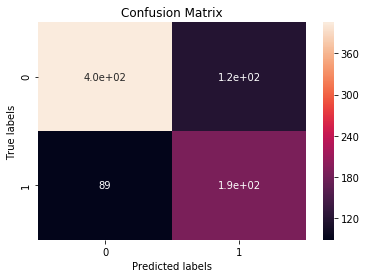

In [37]:
confusionMatrix(y_rumour_val, y_rumour_predictions)

Micro-F1-score 0.692
Macro-F1-score 0.5791031006648775


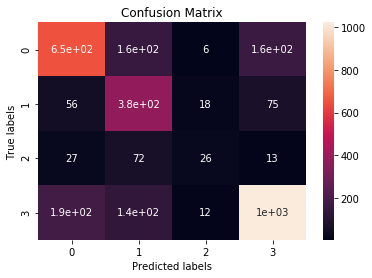

In [38]:
confusionMatrix(y_fakenews_actual, y_fakenews_predictions)

In [39]:
print("F1 macro score rumour model",f1_score(y_rumour_val, y_rumour_predictions, average='macro'))
print("F1 micro score rumour model",f1_score(y_rumour_val, y_rumour_predictions, average='micro'))

print("F1 macro score fakenews model",f1_score(y_fakenews_actual, y_fakenews_predictions, average='macro'))
print("F1 micro score fakenews model",f1_score(y_fakenews_actual, y_fakenews_predictions, average='micro'))


F1 macro score rumour model 0.7191447417279351
F1 micro score rumour model 0.74
F1 macro score fakenews model 0.5791031006648775
F1 micro score fakenews model 0.692


In [40]:
hidden_units1=64
inp1=Input(shape=(100,300))
h1=GRU(units=64)(inp1)
h2=GRU(units=64)(inp1)

o3=Dense(32,activation='relu')(h1)
o3=Dense(8,activation='relu')(o3)
o3=Dense(1,activation='sigmoid')(o3)

o4=Dense(32,activation='relu')(h2)
o4=Dense(16,activation='relu')(o4)
o4=Dense(4,activation='softmax')(o4)

rumour_model1=Model(inputs=[inp1],outputs=[o3])
rumour_model1.summary()

fake_model1=Model(inputs=[inp1],outputs=[o4])
fake_model1.summary()

rumour_model1.compile(optimizer="Adagrad",loss="binary_crossentropy",metrics=[f1])
fake_model1.compile(optimizer="Adagrad",loss="categorical_crossentropy",metrics=[f1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 300)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                70080     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 72,433
Trainable params: 72,433
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_

In [41]:
rumour_model1.fit(x_rumour_train,y_rumour_train,batch_size=32,epochs=3,validation_data=(x_rumour_val,y_rumour_val ))

Train on 4531 samples, validate on 800 samples
Epoch 1/3
4531/4531 [==============================] - 20s 4ms/step - loss: 0.5932 - f1: 0.1662 - val_loss: 0.6088 - val_f1: 0.3080
Epoch 2/3
4531/4531 [==============================] - 18s 4ms/step - loss: 0.5326 - f1: 0.5594 - val_loss: 0.5286 - val_f1: 0.5775
Epoch 3/3
4531/4531 [==============================] - 18s 4ms/step - loss: 0.5123 - f1: 0.6074 - val_loss: 0.5405 - val_f1: 0.5324


In [42]:
fake_model1.fit(x_fakenews_train,y_fakenews_train,batch_size=32,epochs=8,validation_data=(x_fakenews_val,y_fakenews_val))

Train on 17000 samples, validate on 3000 samples
Epoch 1/8
17000/17000 [==============================] - 70s 4ms/step - loss: 1.1107 - f1: 0.3146 - val_loss: 1.0934 - val_f1: 0.4434
Epoch 2/8
17000/17000 [==============================] - 69s 4ms/step - loss: 1.0493 - f1: 0.4072 - val_loss: 1.0351 - val_f1: 0.4733
Epoch 3/8
17000/17000 [==============================] - 68s 4ms/step - loss: 1.0197 - f1: 0.4466 - val_loss: 1.0061 - val_f1: 0.4443
Epoch 4/8
17000/17000 [==============================] - 70s 4ms/step - loss: 0.9903 - f1: 0.4796 - val_loss: 0.9835 - val_f1: 0.4895
Epoch 5/8
17000/17000 [==============================] - 68s 4ms/step - loss: 0.9653 - f1: 0.5125 - val_loss: 0.9639 - val_f1: 0.5105
Epoch 6/8
17000/17000 [==============================] - 68s 4ms/step - loss: 0.9433 - f1: 0.5309 - val_loss: 0.9631 - val_f1: 0.5368
Epoch 7/8
17000/17000 [==============================] - 69s 4ms/step - loss: 0.9267 - f1: 0.5475 - val_loss: 0.9543 - val_f1: 0.5532
Epoch 8/8
170

In [43]:
y_rumour_predictions1 = rumour_model1.predict(x_rumour_val)
# print(y_rumour_predictions.shape)
for i in range(0,y_rumour_predictions1.shape[0]):
    if y_rumour_predictions1[i]>0.5:
        y_rumour_predictions1[i]=1
    else :
        y_rumour_predictions1[i]=0
# np.squeeze(y_rumour_predictions)
y_rumour_predictions1 = y_rumour_predictions1.squeeze()
print(y_rumour_predictions1.shape)
# y_rumour_val= y_rumour_val.reshape((y_rumour_predictions.shape[0],1))
print(y_rumour_val.shape)

(800,)
(800,)


In [44]:
accuracy=0
for i in range(0,y_rumour_val.shape[0]):
    if(y_rumour_val[i]==y_rumour_predictions1[i]):
        accuracy+=1  
print("No of correctly predicted points:",accuracy)
print("Accuracy:", (accuracy*100)/y_rumour_val.shape[0]) 

No of correctly predicted points: 594
Accuracy: 74.25


In [45]:
y_fakenews_predictions1 = fake_model1.predict(x_fakenews_val)
print(y_fakenews_predictions1.shape)
print(y_fakenews_predictions1)
y_fakenews_predictions1=np.argmax(y_fakenews_predictions1,axis=1)
print(y_fakenews_predictions1.shape)
print(y_fakenews_predictions1)
y_fakenews_actual=np.argmax(y_fakenews_val,axis=1)
print(y_fakenews_actual.shape)
print(y_fakenews_actual)

(3000, 4)
[[0.09430002 0.02941806 0.00711679 0.8691651 ]
 [0.34704942 0.28350863 0.05545031 0.31399164]
 [0.23562951 0.05481791 0.03514959 0.67440295]
 ...
 [0.27069992 0.04140913 0.01594665 0.6719443 ]
 [0.15602566 0.0721337  0.01593032 0.7559103 ]
 [0.41761976 0.01490598 0.00218489 0.5652894 ]]
(3000,)
[3 0 3 ... 3 3 3]
(3000,)
[3 1 3 ... 3 3 0]


In [46]:
accuracy=0
for i in range(0,y_fakenews_actual.shape[0]):
    if(y_fakenews_actual[i]==y_fakenews_predictions1[i]):
        accuracy+=1  
print("No of correctly predicted points:",accuracy)
print("Accuracy:", (accuracy*100)/y_fakenews_actual.shape[0]) 

No of correctly predicted points: 1770
Accuracy: 59.0


Micro-F1-score 0.7425
Macro-F1-score 0.6840878419825789


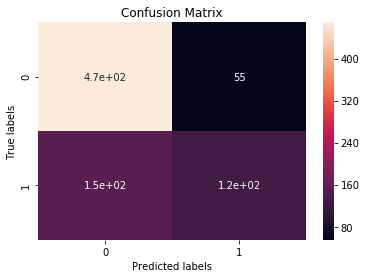

In [47]:
confusionMatrix(y_rumour_val, y_rumour_predictions1)

Micro-F1-score 0.59
Macro-F1-score 0.4683010896359845


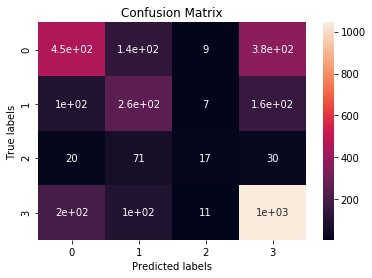

In [48]:
confusionMatrix(y_fakenews_actual, y_fakenews_predictions1)

In [49]:
print("F1 macro score rumour model",f1_score(y_rumour_val, y_rumour_predictions1, average='macro'))
print("F1 micro score rumour model",f1_score(y_rumour_val, y_rumour_predictions1, average='micro'))

print("F1 macro score fakenews model",f1_score(y_fakenews_actual, y_fakenews_predictions1, average='macro'))
print("F1 micro score fakenews model",f1_score(y_fakenews_actual, y_fakenews_predictions1, average='micro'))


F1 macro score rumour model 0.6840878419825789
F1 micro score rumour model 0.7425
F1 macro score fakenews model 0.4683010896359845
F1 micro score fakenews model 0.59
